In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV3Large
from keras.layers import Conv2D,MaxPool2D,AveragePooling2D,Dense,Flatten,ZeroPadding2D,BatchNormalization,Activation,Add,Input,Dropout,GlobalAveragePooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import os
from tensorflow.keras import layers, models
import shutil
import random

## Setting up the dataset

In [2]:
base_dir = "../input/new-plant-diseases-dataset/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)"
image_size = (224,224)
train_dir = os.path.join(base_dir, "train")
valid_dir = os.path.join(base_dir, "valid")
test_dir = '/kaggle/input/new-plant-diseases-dataset/test/test'
# Define the new base directory structure
base_output_dir = '/kaggle/working/dataset'
output_train_dir = os.path.join(base_output_dir, 'train')
output_valid_dir = os.path.join(base_output_dir, 'valid')
output_test_dir = os.path.join(base_output_dir, 'test')

# Create the output directories
os.makedirs(output_train_dir, exist_ok=True)
os.makedirs(output_valid_dir, exist_ok=True)
os.makedirs(output_test_dir, exist_ok=True)

# Copy the training set
for class_folder in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_folder)
    if os.path.isdir(class_path):  # Ensure it's a directory
        # Create the class directory in the output train directory
        output_class_path = os.path.join(output_train_dir, class_folder)
        os.makedirs(output_class_path, exist_ok=True)
        
        # Copy all images to the new class directory
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            if os.path.isfile(img_path):  # Ensure it's a file
                shutil.copy(img_path, output_class_path)

# Copy the validation set
for class_folder in os.listdir(valid_dir):
    class_path = os.path.join(valid_dir, class_folder)
    if os.path.isdir(class_path):  # Ensure it's a directory
        # Create the class directory in the output valid directory
        output_class_path = os.path.join(output_valid_dir, class_folder)
        os.makedirs(output_class_path, exist_ok=True)
        
        # Copy all images to the new class directory
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            if os.path.isfile(img_path):  # Ensure it's a file
                shutil.copy(img_path, output_class_path)


print("Dataset has been reorganized and moved to /kaggle/working/dataset")

Dataset has been reorganized and moved to /kaggle/working/dataset


In [3]:
train_dir = '/kaggle/working/dataset/train'
valid_dir = '/kaggle/working/dataset/valid'
test_dir = '/kaggle/working/dataset/test'

os.makedirs(test_dir, exist_ok=True)

split_ratio = 0.2 


for class_name in os.listdir(valid_dir):
    class_valid_dir = os.path.join(valid_dir, class_name)
    class_test_dir = os.path.join(test_dir, class_name)

    os.makedirs(class_test_dir, exist_ok=True)

    images = [f for f in os.listdir(class_valid_dir) if os.path.isfile(os.path.join(class_valid_dir, f))]
    
    random.shuffle(images)
    num_test_images = int(len(images) * split_ratio)
    test_images = images[:num_test_images]

    for image in test_images:
        src_path = os.path.join(class_valid_dir, image)
        dest_path = os.path.join(class_test_dir, image)
        shutil.move(src_path, dest_path)

    print(f"Moved {len(test_images)} images from '{class_valid_dir}' to '{class_test_dir}'")

Moved 84 images from '/kaggle/working/dataset/valid/Grape___healthy' to '/kaggle/working/dataset/test/Grape___healthy'
Moved 95 images from '/kaggle/working/dataset/valid/Pepper,_bell___Bacterial_spot' to '/kaggle/working/dataset/test/Pepper,_bell___Bacterial_spot'
Moved 95 images from '/kaggle/working/dataset/valid/Corn_(maize)___Common_rust_' to '/kaggle/working/dataset/test/Corn_(maize)___Common_rust_'
Moved 88 images from '/kaggle/working/dataset/valid/Apple___Cedar_apple_rust' to '/kaggle/working/dataset/test/Apple___Cedar_apple_rust'
Moved 84 images from '/kaggle/working/dataset/valid/Cherry_(including_sour)___Powdery_mildew' to '/kaggle/working/dataset/test/Cherry_(including_sour)___Powdery_mildew'
Moved 96 images from '/kaggle/working/dataset/valid/Grape___Esca_(Black_Measles)' to '/kaggle/working/dataset/test/Grape___Esca_(Black_Measles)'
Moved 90 images from '/kaggle/working/dataset/valid/Blueberry___healthy' to '/kaggle/working/dataset/test/Blueberry___healthy'
Moved 88 imag

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input)
val_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input)


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    seed=42,
    class_mode='categorical'
)

# Load validation data
validation_generator = val_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=False
)

Found 70295 images belonging to 38 classes.
Found 14069 images belonging to 38 classes.
Found 3503 images belonging to 38 classes.


## Creating the model + Training

In [6]:
from tensorflow.keras import layers, models

base_model = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  

x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(38, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)

model = models.Model(inputs=base_model.input, outputs=predictions)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',   
    factor=0.5,           
    patience=3,           
    min_lr=1e-6           
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',   
    patience=5,            
    restore_best_weights=True 
)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 112, 112,  │        432 │ rescaling[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 112, 112,  │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 112, 112,  │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        144 │ activation[0][0]  │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        256 │ re_lu[0][0]       │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_add   │ (None, 112, 112,  │          0 │ activation[0][0], │
│ (Add)               │ 16)               │            │ expanded_conv_pr… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 112, 112,  │      1,024 │ expanded_conv_ad… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 112, 112,  │        256 │ expanded_conv_1_… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 112, 112,  │          0 │ expanded_conv_1_… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 113, 113,  │          0 │ re_lu_1[0][0]     │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 56, 56,    │        576 │ expanded_conv_1_… │
│ (DepthwiseConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 56, 56,    │        256 │ expanded_conv_1_

 Total params: 3,507,878 (13.38 MB)

 Trainable params: 511,526 (1.95 MB)

 Non-trainable params: 2,996,352 (11.43 MB)

In [7]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=130,
    callbacks=[reduce_lr, early_stopping]
)


Epoch 1/130


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1732262997.686539     152 service.cc:145] XLA service 0x7bc35803e6e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732262997.686615     152 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


   4/2197 ━━━━━━━━━━━━━━━━━━━━ 2:03 57ms/step - accuracy: 0.0293 - loss: 6.3620 

I0000 00:00:1732263005.645956     152 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2197/2197 ━━━━━━━━━━━━━━━━━━━━ 145s 60ms/step - accuracy: 0.0537 - loss: 5.1941 - val_accuracy: 0.5372 - val_loss: 3.1896 - learning_rate: 1.0000e-05
Epoch 2/130
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 106s 48ms/step - accuracy: 0.2216 - loss: 3.6438 - val_accuracy: 0.7162 - val_loss: 2.4813 - learning_rate: 1.0000e-05
Epoch 3/130
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 108s 49ms/step - accuracy: 0.3742 - loss: 2.9588 - val_accuracy: 0.7941 - val_loss: 1.9386 - learning_rate: 1.0000e-05
Epoch 4/130
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 107s 48ms/step - accuracy: 0.4801 - loss: 2.5061 - val_accuracy: 0.8330 - val_loss: 1.5871 - learning_rate: 1.0000e-05
Epoch 5/130
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 110s 50ms/step - accuracy: 0.5517 - loss: 2.2035 - val_accuracy: 0.8590 - val_loss: 1.3684 - learning_rate: 1.0000e-05
Epoch 6/130
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 108s 49ms/step - accuracy: 0.6061 - loss: 1.9744 - val_accuracy: 0.8758 - val_loss: 1.2277 - learning_rate: 1.0000e-05
Epoch 7/130
2197/2197 ━━━━━━━━━━━━━━━━━━

## evaluating the model + testing

In [8]:
def evaluate_model(model, dataset):
    results = model.evaluate(dataset)
    print(f"Test Loss: {results[0]}, Test Accuracy: {results[1]}")

# Evaluate on validation set
evaluate_model(model, test_generator)

110/110 ━━━━━━━━━━━━━━━━━━━━ 9s 78ms/step - accuracy: 0.9792 - loss: 0.2781
Test Loss: 0.31875601410865784, Test Accuracy: 0.9694547653198242


## Picking 2 samples from test folder for prediction

In [12]:
def predict_image(img_path, model, class_names):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch of size 1
    
    img_array = tf.keras.applications.mobilenet_v3.preprocess_input(img_array)
    
    predictions = model.predict(img_array)
    
    predicted_class = np.argmax(predictions[0])
    confidence = np.max(predictions[0]) * 100
    
    return predicted_class, confidence

class_names = list(train_generator.class_indices.keys())
print("Training dataset class names:", class_names)

test_dir_images = "/kaggle/working/dataset/test"  

correct_predictions = 0
total_predictions = 0

for class_dir in os.listdir(test_dir_images):
    class_path = os.path.join(test_dir_images, class_dir)
    
    if os.path.isdir(class_path): 
        image_names = os.listdir(class_path)
        
        sampled_images = random.sample(image_names, 2) if len(image_names) > 2 else image_names
        
        for img_name in sampled_images:
            img_path = os.path.join(class_path, img_name)
            
            true_label = class_names.index(class_dir)
            
            predicted_class, confidence = predict_image(img_path, model, class_names)
            
            total_predictions += 1
            if predicted_class == true_label:
                correct_predictions += 1

            print(f'Image: {img_name}, True Label: {class_dir}, Predicted Class: {class_names[predicted_class]}, Confidence: {confidence:.2f}%')

# Calculate accuracy
accuracy = correct_predictions / total_predictions * 100 if total_predictions > 0 else 0
print(f"Accuracy: {accuracy:.2f}%")

Training dataset class names: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spi

In [16]:
import numpy as np
test_dir_images = "/kaggle/input/new-plant-diseases-dataset/test/test"
test_images = sorted(os.listdir(test_dir_images))
def predict_image(img_path, model):
    
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  
    
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions[0])
    confidence = np.max(predictions[0]) * 100
    
    return class_names[predicted_class], confidence

for img_name in test_images:
    img_path = os.path.join(test_dir_images, img_name)
    predicted_label = predict_image(img_path, model)
    print('Label:', img_name, ', Predicted:', predicted_label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Label: AppleCedarRust1.JPG , Predicted: ('Apple___Cedar_apple_rust', 99.71308708190918)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Label: AppleCedarRust2.JPG , Predicted: ('Apple___Cedar_apple_rust', 98.83241653442383)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Label: AppleCedarRust3.JPG , Predicted: ('Apple___Cedar_apple_rust', 97.65185713768005)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Label: AppleCedarRust4.JPG , Predicted: ('Apple___Cedar_apple_rust', 99.8583436012268)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Label: AppleScab1.JPG , Predicted: ('Apple___Apple_scab', 95.7461416721344)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Label: AppleScab2.JPG , Predicted: ('Apple___Apple_scab', 99.276864528656)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Label: AppleScab3.JPG , Predicted: ('Apple___Apple_scab', 50.10826587677002)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Label: CornCommonRust1.JPG , Predicted: ('Corn_(maize)___Common_rust_', 99.90246295928955)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


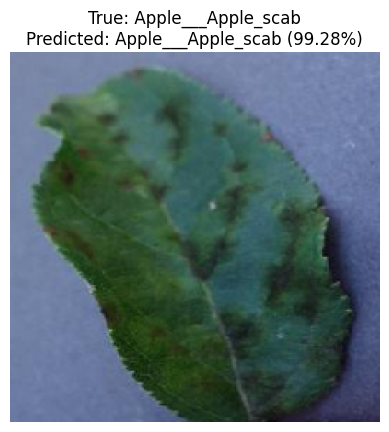

In [23]:
import matplotlib.pyplot as plt


def plot_image_with_prediction(img_path, true_label, model):
    predicted_label, confidence = predict_image(img_path, model)
    
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    
    plt.imshow(img)
    plt.axis('off')
    
    plt.title(f"True: {true_label}\nPredicted: {predicted_label} ({confidence:.2f}%)")
    plt.show()


test_image_path = os.path.join(test_dir_images, test_images[5])
true_label = "Apple___Apple_scab"  # Replace with actual label for the image

plot_image_with_prediction(test_image_path, true_label, model)

In [17]:
import keras
print(keras.__version__)


3.3.3


In [30]:
model_save_path = '/kaggle/working/Mobilenetv3large_Plant_disease_detection.keras'
model.save(model_save_path)

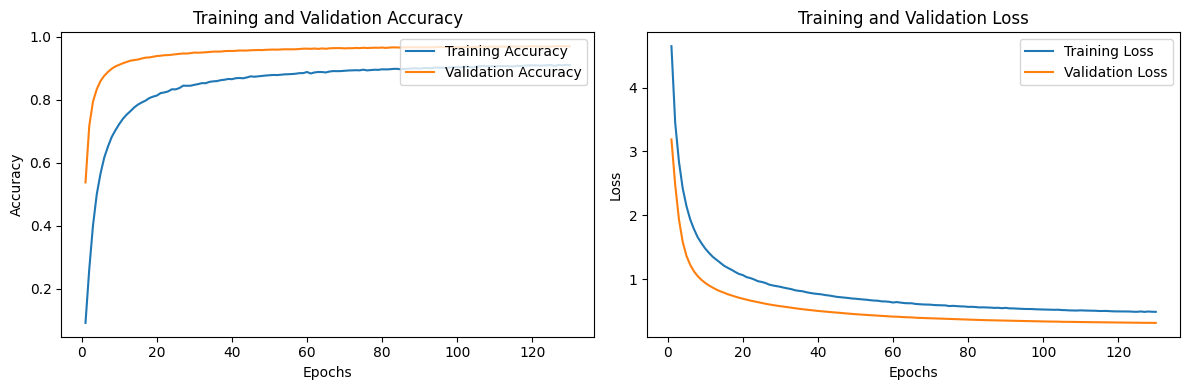

In [21]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()

In [31]:
import subprocess
from IPython.display import FileLink, display

def download_file(path, download_file_name):
    os.chdir('/kaggle/working/')
    zip_name = f"/kaggle/working/{download_file_name}.zip"
    command = f"zip {zip_name} {path} -r"
    result = subprocess.run(command, shell=True, capture_output=True, text=True)
    if result.returncode != 0:
        print("Unable to run zip command!")
        print(result.stderr)
        return
    display(FileLink(f'{download_file_name}.zip'))
    
download_file('/kaggle/working/Mobilenetv3large_Plant_disease_detection.keras', 'out')

/kaggle/working/out.zip

In [26]:
model.export("Mobilenetv3large_Plant_disease_detection")


Saved artifact at 'Mobilenetv3large_Plant_disease_detection'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 38), dtype=tf.float32, name=None)
Captures:
  136080811230128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136080266381440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136080266384256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136080266382144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136080266381616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136080266388304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136080266388128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136080266392000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136080266388832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136080266390416: TensorSpec(shape=(), dtype=tf.resource, na

In [27]:
!zip -r Mobilenetv3large_Plant_disease_detect.zip /kaggle/working/Mobilenetv3large_Plant_disease_detection


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


  adding: kaggle/working/Mobilenetv3large_Plant_disease_detection/ (stored 0%)
  adding: kaggle/working/Mobilenetv3large_Plant_disease_detection/saved_model.pb (deflated 90%)
  adding: kaggle/working/Mobilenetv3large_Plant_disease_detection/assets/ (stored 0%)
  adding: kaggle/working/Mobilenetv3large_Plant_disease_detection/variables/ (stored 0%)
  adding: kaggle/working/Mobilenetv3large_Plant_disease_detection/variables/variables.index (deflated 76%)
  adding: kaggle/working/Mobilenetv3large_Plant_disease_detection/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: kaggle/working/Mobilenetv3large_Plant_disease_detection/fingerprint.pb (stored 0%)
